# Convolutional Neural Network (CNN) from Scratch - MNIST Dataset

## Introduction

This notebook implements a **Convolutional Neural Network (CNN)** from scratch using PyTorch for handwritten digit recognition on the **MNIST dataset**.

### What we'll cover:
1. **Understanding CNNs**: Learn about convolutional layers, pooling, and fully connected layers
2. **MNIST Dataset**: Load and preprocess 28×28 grayscale digit images
3. **Build CNN Architecture**: Create a custom CNN using PyTorch's nn.Module
4. **Training Loop**: Implement forward pass, backpropagation, and optimization
5. **Model Evaluation**: Test accuracy on unseen data

---

## What is a Convolutional Neural Network?

CNNs are deep learning architectures specifically designed for processing **grid-like data** such as images. They consist of three main types of layers:

### 1. **Convolutional Layers**
- Apply filters (kernels) that slide over the input image
- Extract local features like edges, textures, and patterns
- Use **parameter sharing** to reduce the number of weights

### 2. **Pooling Layers**
- Reduce spatial dimensions (downsampling)
- Provide **translation invariance** (object detection regardless of position)
- Common types: Max Pooling, Average Pooling

### 3. **Fully Connected Layers**
- Traditional neural network layers
- Map extracted features to output classes
- Perform final classification

---

## MNIST Dataset Overview

- **70,000 grayscale images** of handwritten digits (0-9)
- **60,000 training images** + **10,000 test images**
- Each image is **28×28 pixels** (single channel - grayscale)
- **10 classes** representing digits 0 through 9

---

## Step 1: Import Required Libraries

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
# Check PyTorch version and CUDA availability
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch Version: 2.9.1+cpu
CUDA Available: False
Device: cpu


## Step 2: Load and Preprocess MNIST Dataset

### Data Transformations:
- **ToTensor()**: Converts PIL Image to PyTorch tensor (values in [0, 1])
- **Normalize()**: Normalizes with mean=0.5 and std=0.5 (values in [-1, 1])

### Why Normalize?
Normalization helps the model converge faster during training by keeping input values in a similar range.

In [9]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Mean=0.5, Std=0.5 for grayscale
])

# Load the training and test datasets
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders for batch processing
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of batches (train): {len(trainloader)}")
print(f"Number of batches (test): {len(testloader)}")

100.0%
100.0%
100.0%
100.0%


Training samples: 60000
Test samples: 10000
Number of batches (train): 938
Number of batches (test): 157


## Step 3: Visualize Sample Images

Visualize some sample digits from the MNIST dataset to understand what we're working with.

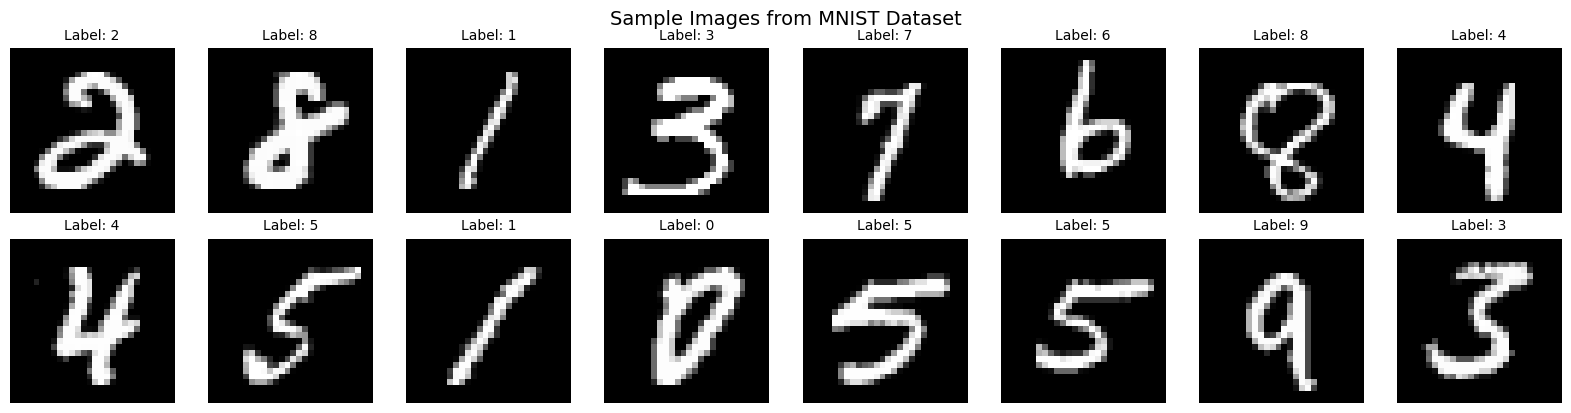

In [10]:
# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Function to display images
def imshow(img, title=None):
    """Display a tensor image"""
    img = img / 2 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')

# Display sample images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for idx in range(16):
    ax = axes[idx // 8, idx % 8]
    img = images[idx] / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    ax.imshow(npimg.squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[idx]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from MNIST Dataset', y=1.02, fontsize=14)
plt.show()

## Step 4: Define the CNN Architecture

### Network Architecture:

**Input**: 28×28×1 grayscale image

1. **Convolutional Layer 1**:
   - Input channels: 1 (grayscale)
   - Output channels: 16
   - Kernel size: 3×3
   - Padding: 1 (keeps spatial size)
   - Output: 28×28×16

2. **Max Pooling 1**:
   - Kernel: 2×2
   - Stride: 2
   - Output: 14×14×16

3. **Convolutional Layer 2**:
   - Input channels: 16
   - Output channels: 32
   - Kernel size: 3×3
   - Padding: 1
   - Output: 14×14×32

4. **Max Pooling 2**:
   - Kernel: 2×2
   - Stride: 2
   - Output: 7×7×32

5. **Flatten**: 7×7×32 = 1568 features

6. **Fully Connected Layer 1**:
   - Input: 1568
   - Output: 128
   - Activation: ReLU

7. **Fully Connected Layer 2** (Output):
   - Input: 128
   - Output: 10 (digit classes)

In [11]:
class Net(nn.Module):
    """
    Simple Convolutional Neural Network for MNIST digit classification.
    
    Architecture:
        - Conv1: 1 -> 16 channels (3x3 kernel, padding=1)
        - MaxPool: 2x2
        - Conv2: 16 -> 32 channels (3x3 kernel, padding=1)
        - MaxPool: 2x2
        - FC1: 1568 -> 128
        - FC2: 128 -> 10 (output classes)
    """
    
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 28x28x1 -> 28x28x16
        self.pool = nn.MaxPool2d(2, 2)  # Reduces size by half
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 14x14x16 -> 14x14x32
        
        # Fully connected layers
        # After 2 pooling layers: 28 -> 14 -> 7, so 7*7*32 = 1568
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)
            
        Returns:
            torch.Tensor: Output logits of shape (batch_size, 10)
        """
        # First conv block: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))  # 28x28x16 -> 14x14x16
        
        # Second conv block: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # 14x14x32 -> 7x7x32
        
        # Flatten: 7*7*32 = 1568
        x = x.view(-1, 32 * 7 * 7)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # 1568 -> 128
        x = self.fc2(x)  # 128 -> 10
        
        return x

# Instantiate the network
net = Net()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

print("=" * 70)
print("CNN Architecture")
print("=" * 70)
print(net)
print("=" * 70)

# Count parameters
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

CNN Architecture
Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total Parameters: 206,922
Trainable Parameters: 206,922


## Step 5: Define Loss Function and Optimizer

### Loss Function: CrossEntropyLoss
- Combines **softmax activation** and **negative log-likelihood**
- Ideal for multi-class classification (10 digit classes)
- Measures how different predicted probabilities are from true labels

### Optimizer: SGD with Momentum
- **Stochastic Gradient Descent (SGD)**: Updates weights in direction of negative gradient
- **Learning Rate (lr=0.001)**: Controls step size for weight updates
- **Momentum (0.9)**: Accumulates past gradients to accelerate convergence and reduce oscillations

In [12]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss Function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## Step 6: Train the CNN Model

### Training Process:

1. **Forward Pass**: Input batch through network → Get predictions
2. **Compute Loss**: Compare predictions with true labels
3. **Backward Pass**: Calculate gradients via backpropagation
4. **Update Weights**: Optimizer adjusts parameters using gradients

### Key Operations:
- `optimizer.zero_grad()`: Clear gradients from previous iteration
- `loss.backward()`: Compute gradients for all parameters
- `optimizer.step()`: Update weights using computed gradients

We'll train for **5 epochs** and print loss every 200 mini-batches.

In [13]:
# Training loop
num_epochs = 5
train_losses = []

print("Starting Training...")
print("=" * 70)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Move data to device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        outputs = net(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss for statistics
        running_loss += loss.item()
        
        # Print statistics every 200 mini-batches
        if i % 200 == 199:
            avg_loss = running_loss / 200
            train_losses.append(avg_loss)
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {avg_loss:.3f}')
            running_loss = 0.0

print('=' * 70)
print('Finished Training')

Starting Training...
[Epoch 1, Batch   200] loss: 2.261
[Epoch 1, Batch   400] loss: 1.780
[Epoch 1, Batch   600] loss: 0.667
[Epoch 1, Batch   800] loss: 0.401
[Epoch 2, Batch   200] loss: 0.302
[Epoch 2, Batch   400] loss: 0.272
[Epoch 2, Batch   600] loss: 0.237
[Epoch 2, Batch   800] loss: 0.207
[Epoch 3, Batch   200] loss: 0.185
[Epoch 3, Batch   400] loss: 0.152
[Epoch 3, Batch   600] loss: 0.162
[Epoch 3, Batch   800] loss: 0.148
[Epoch 4, Batch   200] loss: 0.121
[Epoch 4, Batch   400] loss: 0.123
[Epoch 4, Batch   600] loss: 0.121
[Epoch 4, Batch   800] loss: 0.105
[Epoch 5, Batch   200] loss: 0.097
[Epoch 5, Batch   400] loss: 0.097
[Epoch 5, Batch   600] loss: 0.092
[Epoch 5, Batch   800] loss: 0.091
Finished Training


## Step 7: Visualize Training Loss

Plotting the training loss over time to see how the model is learning.

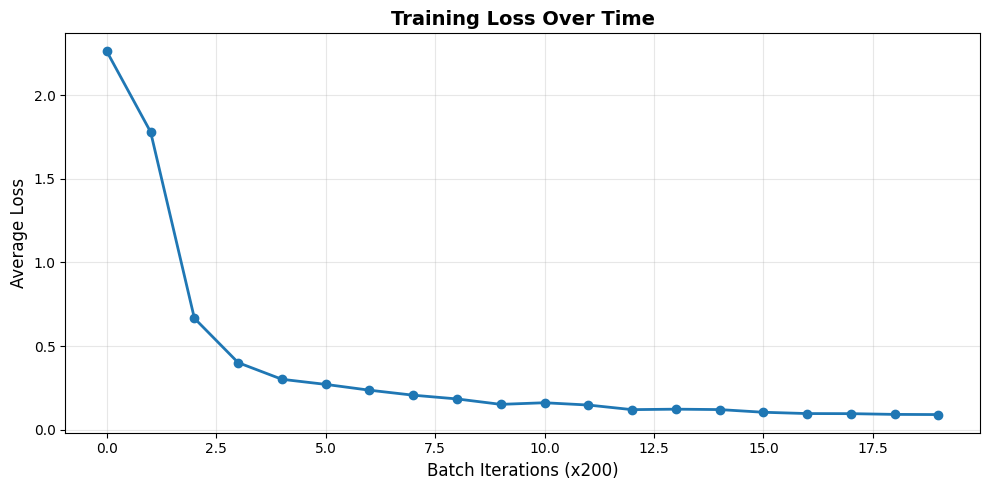

In [14]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o', linestyle='-', linewidth=2)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Batch Iterations (x200)', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 8: Evaluate Model on Test Set

Now we evaluate our trained model on the **test dataset** to see how well it generalizes to unseen data.

### Evaluation Process:
- Use `torch.no_grad()` to disable gradient computation (saves memory and speeds up)
- Make predictions on test images
- Compare predictions with true labels
- Calculate accuracy as percentage of correct predictions

In [15]:
# Evaluate on test set
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = net(images)
        
        # Get predicted class (class with highest score)
        _, predicted = torch.max(outputs.data, 1)
        
        # Count total samples
        total += labels.size(0)
        
        # Count correct predictions
        correct += (predicted == labels).sum().item()

# Calculate and display accuracy
accuracy = 100 * correct / total
print("=" * 70)
print(f'Accuracy of the network on the 10,000 test images: {accuracy:.2f}%')
print("=" * 70)

Accuracy of the network on the 10,000 test images: 97.60%


## Step 9: Per-Class Accuracy Analysis

Then we analyze how well the model performs on each individual digit class.

In [16]:
# Calculate per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        # Compare predictions with labels
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Display per-class accuracy
print("\nPer-Class Accuracy:")
print("=" * 70)
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of digit {i}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})')
print("=" * 70)


Per-Class Accuracy:
Accuracy of digit 0: 99.18% (972/980)
Accuracy of digit 1: 99.30% (1127/1135)
Accuracy of digit 2: 97.58% (1007/1032)
Accuracy of digit 3: 95.94% (969/1010)
Accuracy of digit 4: 99.19% (974/982)
Accuracy of digit 5: 97.65% (871/892)
Accuracy of digit 6: 97.49% (934/958)
Accuracy of digit 7: 96.79% (995/1028)
Accuracy of digit 8: 96.82% (943/974)
Accuracy of digit 9: 95.94% (968/1009)


## Step 10: Visualize Predictions

We now visualize some test images along with their predictions to see how the model performs.

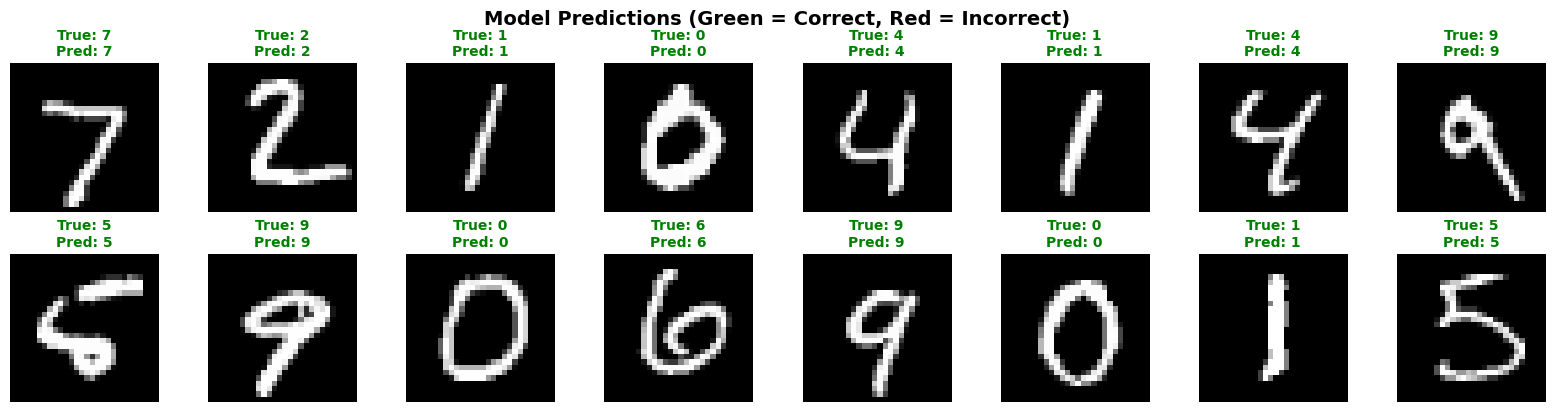

In [17]:
# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move to device and get predictions
images_gpu = images.to(device)
outputs = net(images_gpu)
_, predicted = torch.max(outputs, 1)

# Move back to CPU for visualization
images = images.cpu()
predicted = predicted.cpu()

# Display predictions
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for idx in range(16):
    ax = axes[idx // 8, idx % 8]
    img = images[idx] / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    ax.imshow(npimg.squeeze(), cmap='gray')
    
    # Color code: green for correct, red for incorrect
    color = 'green' if predicted[idx] == labels[idx] else 'red'
    ax.set_title(f'True: {labels[idx]}\nPred: {predicted[idx]}', 
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.suptitle('Model Predictions (Green = Correct, Red = Incorrect)', 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()


---

## References

- **PyTorch Documentation**: https://pytorch.org/docs/stable/index.html
- **MNIST Dataset**: http://yann.lecun.com/exdb/mnist/
- **Tutorial Source**: https://www.codegenes.net/blog/pytorch-convolutional-neural-network-minist-from-scratch/
- **CNNs Explained**: https://cs231n.github.io/convolutional-networks/

---